Iter 0 | Loss total=76.240135 | Phys=7.001285 | Obs=6.227285
Iter 2000 | Loss total=4.782547 | Phys=0.000987 | Obs=4.772676
Iter 4000 | Loss total=3.627925 | Phys=0.003673 | Obs=3.591200
Iter 6000 | Loss total=3.467155 | Phys=0.000862 | Obs=3.458535
Iter 8000 | Loss total=2.420981 | Phys=0.004179 | Obs=2.379195
Iter 10000 | Loss total=2.030118 | Phys=0.002759 | Obs=2.002532
Iter 12000 | Loss total=1.765322 | Phys=0.002230 | Obs=1.743017
Iter 14000 | Loss total=1.199440 | Phys=0.002934 | Obs=1.170099
Iter 16000 | Loss total=1.055002 | Phys=0.003030 | Obs=1.024703
Iter 18000 | Loss total=1.005901 | Phys=0.002616 | Obs=0.979744
Iter 20000 | Loss total=0.985721 | Phys=0.005172 | Obs=0.934000
Iter 22000 | Loss total=0.835907 | Phys=0.001965 | Obs=0.816257
Iter 24000 | Loss total=0.206433 | Phys=0.003374 | Obs=0.172693
Iter 26000 | Loss total=0.097498 | Phys=0.001674 | Obs=0.080759
Iter 28000 | Loss total=0.073762 | Phys=0.001438 | Obs=0.059378
Iter 30000 | Loss total=0.070559 | Phys=0.00149

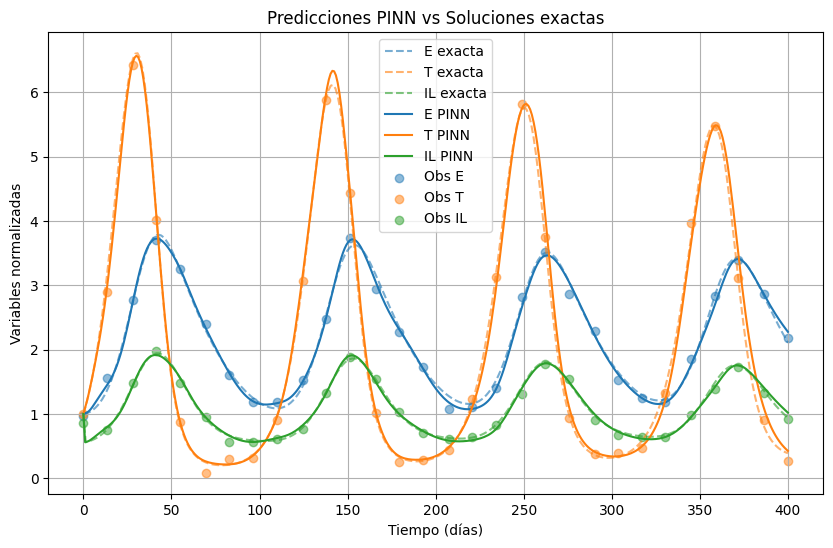

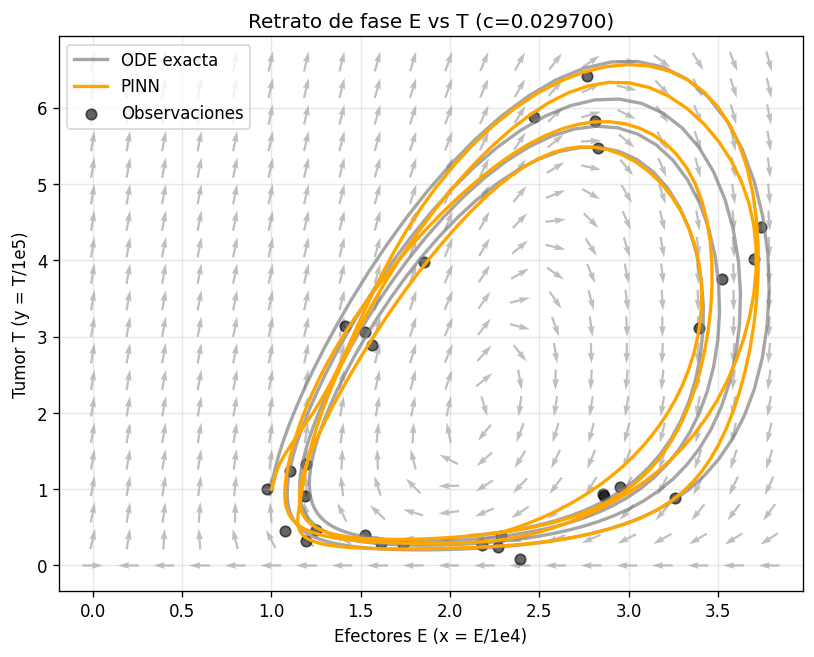

In [ ]:
#  Librerías

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go


# 2. Modelo Kirschner–Panetta normalizado

p1, g1, mu2, r2, b, a, g2, mu3, p2, g3, c, s1, s2 = \
    0.1245, 2e3, 0.03, 0.18, 1e-5, 1.0, 1e1, 10.0, 5.0, 1e-1, 0.0297, 45e-4, 100000e-5

def dP_dt(P, t):
    x, y, z = P
    dx = c*y - mu2*x + p1*x*z/(g1 + z) + s1
    dy = r2*y*(1 - b*y) - a*x*y/(g2 + y)
    dz = p2*x*y/(g3 + y) - mu3*z + s2
    return [dx, dy, dz]

t = np.linspace(0, 400, 300)
P0 = [1.0, 1.0, 1.0]
datos_sol = odeint(dP_dt, P0, t)
x, y, z = datos_sol[:,0], datos_sol[:,1], datos_sol[:,2]


# Datos exactos y observacionales
 
t_values  = torch.tensor(t, dtype=torch.float32).view(-1, 1)
E_values  = torch.tensor(x, dtype=torch.float32).view(-1, 1)
T_values  = torch.tensor(y, dtype=torch.float32).view(-1, 1)
IL_values = torch.tensor(z, dtype=torch.float32).view(-1, 1)

torch.manual_seed(40)
n_obs = 30
N = t_values.shape[0]
idx_obs = torch.linspace(0, N-1, steps=n_obs).round().long()
t_obs = t_values[idx_obs]
E_obs, T_obs, IL_obs = E_values[idx_obs], T_values[idx_obs], IL_values[idx_obs]

sigma_E  = 0.05 * E_obs.mean()
sigma_T  = 0.05 * T_obs.mean()
sigma_IL = 0.05 * IL_obs.mean()

E_obs_r  = torch.clamp(E_obs  + sigma_E  * torch.randn_like(E_obs),  min=0.0)
T_obs_r  = torch.clamp(T_obs  + sigma_T  * torch.randn_like(T_obs),  min=0.0)
IL_obs_r = torch.clamp(IL_obs + sigma_IL * torch.randn_like(IL_obs), min=0.0)


# Red neuronal con ansatz

class FCN_Ansatz(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, E0, T0, IL0):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.fch = nn.Sequential(*[
            nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation())
            for _ in range(N_LAYERS - 1)
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.register_buffer("E0", torch.tensor([[E0]], dtype=torch.float32))
        self.register_buffer("T0", torch.tensor([[T0]], dtype=torch.float32))
        self.register_buffer("IL0", torch.tensor([[IL0]], dtype=torch.float32))
    def forward(self, t):
        N = self.fce(self.fch(self.fcs(t)))
        mask = (1 - torch.exp(-5*t))
        E_hat  = self.E0  + mask * N[:,0:1]
        T_hat  = self.T0  + mask * N[:,1:2]
        IL_hat = self.IL0 + mask * N[:,2:3]
        return torch.cat([E_hat, T_hat, IL_hat], dim=1)


# Configuración PINN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PINN = FCN_Ansatz(1, 3, 32, 3, E0=1.0, T0=1.0, IL0=1.0).to(device)

t_values, E_values, T_values, IL_values = [d.to(device) for d in [t_values, E_values, T_values, IL_values]]
t_obs, E_obs_r, T_obs_r, IL_obs_r = [d.to(device) for d in [t_obs, E_obs_r, T_obs_r, IL_obs_r]]

t_f = 400
t_physics = torch.tensor((np.polynomial.legendre.leggauss(150)[0] + 1) / 2 * t_f,
                         dtype=torch.float32, device=device).reshape(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, t_f, 400, device=device).view(-1, 1)

params = [p1, g1, mu2, r2, b, a, g2, mu3, p2, g3, c, s1, s2]
p1_t, g1_t, mu2_t, r2_t, b_t, a_t, g2_t, mu3_t, p2_t, g3_t, c_t, s1_t, s2_t = \
    [torch.tensor(val, dtype=torch.float32, device=device) for val in params]

optimiser = torch.optim.Adam(PINN.parameters(), lr=1e-3, weight_decay=1e-4)


# Entrenamiento

for i in range(100001):
    optimiser.zero_grad()
    u, v, w = PINN(t_physics).split(1, dim=1)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    dvdt = torch.autograd.grad(v, t_physics, torch.ones_like(v), create_graph=True)[0]
    dwdt = torch.autograd.grad(w, t_physics, torch.ones_like(w), create_graph=True)[0]
    rhs_E  = c_t*v - mu2_t*u + (p1_t*u*w)/(g1_t + w) + s1_t
    rhs_T  = r2_t*v*(1 - b_t*v) - a_t*u*v/(g2_t + v)
    rhs_IL = (p2_t*u*v)/(g3_t + v) - mu3_t*w + s2_t
    loss_phys = torch.mean((dudt - rhs_E)**2) + torch.mean((dvdt - rhs_T)**2) + torch.mean((dwdt - rhs_IL)**2)
    u_obs_pred, v_obs_pred, w_obs_pred = PINN(t_obs).split(1, dim=1)
    loss_obs = torch.mean((u_obs_pred - E_obs_r)**2) + torch.mean((v_obs_pred - T_obs_r)**2) + torch.mean((w_obs_pred - IL_obs_r)**2)
    loss = 10*loss_phys + loss_obs
    loss.backward(); optimiser.step()
    if i % 2000 == 0:
        print(f"Iter {i} | Loss total={loss.item():.6f} | Phys={loss_phys.item():.6f} | Obs={loss_obs.item():.6f}")


# Predicciones PINN

with torch.no_grad():
    u_pred, v_pred, w_pred = PINN(t_test).split(1, dim=1)

T_phase = v_pred.cpu().numpy().flatten()
E_phase = u_pred.cpu().numpy().flatten()
t_phase = t_test.cpu().numpy().flatten()


# Visualización temporal

plt.figure(figsize=(10,6))
plt.plot(t_values.cpu(), E_values.cpu(), '--', color='tab:blue', alpha=0.6, label='E exacta')
plt.plot(t_values.cpu(), T_values.cpu(), '--', color='tab:orange', alpha=0.6, label='T exacta')
plt.plot(t_values.cpu(), IL_values.cpu(), '--', color='tab:green', alpha=0.6, label='IL exacta')
plt.plot(t_test.cpu(), u_pred.cpu(), color='tab:blue', label='E PINN')
plt.plot(t_test.cpu(), v_pred.cpu(), color='tab:orange', label='T PINN')
plt.plot(t_test.cpu(), w_pred.cpu(), color='tab:green', label='IL PINN')
plt.scatter(t_obs.cpu(), E_obs_r.cpu(), color='tab:blue', alpha=0.5, label='Obs E')
plt.scatter(t_obs.cpu(), T_obs_r.cpu(), color='tab:orange', alpha=0.5, label='Obs T')
plt.scatter(t_obs.cpu(), IL_obs_r.cpu(), color='tab:green', alpha=0.5, label='Obs IL')
plt.xlabel("Tiempo (días)"); plt.ylabel("Variables normalizadas")
plt.title("Predicciones PINN vs Soluciones exactas")
plt.legend(); plt.grid(True); plt.show()


# Retrato de fase 2D

N = 20
E_max = max(float(u_pred.max()), float(E_values.max()))
T_max = max(float(v_pred.max()), float(T_values.max()))
E_lin, T_lin = np.linspace(0, E_max, N), np.linspace(0, T_max, N)
EE, TT = np.meshgrid(E_lin, T_lin)
DX = c*TT - mu2*EE + (p1*EE*1.0)/(g1 + 1.0) + s1
DY = r2*TT*(1 - b*TT) - a*EE*TT/(g2 + TT)
M = np.hypot(DX, DY); M[M == 0] = 1.0; DX, DY = DX/M, DY/M
plt.figure(figsize=(8,6), dpi=120)
plt.title(f"Retrato de fase E vs T (c={c:.6f})")
plt.quiver(EE, TT, DX, DY, color="gray", alpha=0.5, pivot="mid")
plt.plot(E_values.cpu(), T_values.cpu(), 'gray', lw=2, alpha=0.7, label="ODE exacta")
plt.plot(u_pred.cpu(), v_pred.cpu(), 'orange', lw=2, label="PINN")
plt.scatter(E_obs_r.cpu(), T_obs_r.cpu(), color="black", s=40, alpha=0.6, label="Observaciones")
plt.xlabel("Efectores E (x = E/1e4)"); plt.ylabel("Tumor T (y = T/1e5)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()


# Diagrama de fase 3D 

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=T_values.cpu().numpy().flatten(),
                           y=E_values.cpu().numpy().flatten(),
                           z=t_values.cpu().numpy().flatten(),
                           mode="lines", line=dict(color="blue", width=4, dash="dash"),
                           name="ODE exacta"))
fig.add_trace(go.Scatter3d(x=T_phase, y=E_phase, z=t_phase,
                           mode="lines", line=dict(color="red", width=5), name="PINN"))
fig.add_trace(go.Scatter3d(x=T_obs.cpu().numpy().flatten(),
                           y=E_obs_r.cpu().numpy().flatten(),
                           z=t_obs.cpu().numpy().flatten(),
                           mode="markers", marker=dict(size=5, color="black"),
                           name="Observaciones"))
fig.update_layout(width=1100, height=850, margin=dict(l=0, r=0, t=60, b=0),
                  scene=dict(xaxis_title="Tumor (T/1e5)", yaxis_title="Efectores (E/1e4)",
                             zaxis_title="Tiempo (días)", aspectmode="cube",
                             camera=dict(eye=dict(x=1.6, y=1.6, z=1.2))),
                  title="Diagrama de fase 3D (ODE vs PINN vs Obs)",
                  legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0.7)"))
fig.show()
